## This notebook is modified from a Winter 2021 DASC 522 student


# Define a confusion matrix function

In [1]:
# This is from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [30]:
# ------ Common formating options ---------
plt.style.use('seaborn-whitegrid')

SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40

plt.rc('font', size=MEDIUM_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)      # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams["figure.figsize"] = (15,10)
# ------ end format ---------

# Import Data and Basic Data Prep

Data understanding

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
print(" ")

df = pd.read_csv('NLP Training data.csv', engine='python')

print(" ")
df.info()
print(" ")

print("---1st 15 job titles---")
for loop in range(0,14):
  print(df['JobTitle'][loop])

print(" ")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   User ID                365 non-null    int64 
 1   Professional Field     65 non-null     object
 2   Organization           243 non-null    object
 3   Military or Civilian:  363 non-null    object
 4   JobTitle               365 non-null    object
 5   Country/Region Name    365 non-null    object
 6   Likes Lattes           365 non-null    object
dtypes: int64(1), object(6)
memory usage: 20.1+ KB
 
---1st 15 job titles---
Operations Sergeant
Senior Advisor
South East Asia Branch Chief/CG LNO
Professor
Masters in Marine Affairs Candidate
Intel Specialist
SOJ7 Director
Fellow
Supervisory Special Agent
Exercise Scenario Developer
Instructional systems specialist
Cou

Standardize text 

In [32]:
# df['JobTitle']=df['JobTitle'].astype(str)


# df['JobTitle'] = df.JobTitle.str.replace('[^a-zA-Z ]', ' ')  #Removes numbers and non alphabet characters (slashes, punctuation, etc)
df['JobTitle'] = df.JobTitle.str.replace('[^a-zA-Z0-9 ]', ' ')   #Removes numbers non alphabet characters
df['JobTitle'] = df.JobTitle.str.lower()  #Makes all text lower case (Makes sure AFI and afi (i.e. policy indicators) are treated the same

print("---1st 15 job titles---")
for loop in range(0,14):
  print(df['JobTitle'][loop])

print(" ")



---1st 15 job titles---
operations sergeant
senior advisor
south east asia branch chief cg lno
professor
masters in marine affairs candidate
intel specialist
soj7 director
fellow
supervisory special agent
exercise scenario developer
instructional systems specialist
counter threat finance  ctf  analyst
company commander
special agent
 


Print dataset

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   User ID                365 non-null    int64 
 1   Professional Field     65 non-null     object
 2   Organization           243 non-null    object
 3   Military or Civilian:  363 non-null    object
 4   JobTitle               365 non-null    object
 5   Country/Region Name    365 non-null    object
 6   Likes Lattes           365 non-null    object
dtypes: int64(1), object(6)
memory usage: 20.1+ KB


Tokenize

In [34]:

df['JobTitle'] = df.apply(lambda row: nltk.word_tokenize(row['JobTitle']), axis=1)
#Removes full string list in "subject" and turns it into a list of words


nltk.download('stopwords')
from nltk.corpus import stopwords
for row in df['JobTitle']:
  for x in row:
    if x in stopwords.words('english'): row.remove(x)
#removes "stop words" like "for", "a", "the", etc
df

print(" ")

for loop in range(1,5):
  print(df['JobTitle'][loop])

print(" ")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
 
['senior', 'advisor']
['south', 'east', 'asia', 'branch', 'chief', 'cg', 'lno']
['professor']
['masters', 'marine', 'affairs', 'candidate']
 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,director,officer,chief,analyst,deputy,professor,retired,senior,assistant,general,staff,specialist,police,advisor,fellow,commander,planner,security,intelligence,division,head,faculty,manager,foreign,retd,regional,ambassador,student,major,sme,research,asia,branch,supervisory,special,agent,attorney,team,alumni,associate,military,information,coordinator,service,consultant,air,secretary,expert,force,defence
1,38,29,26,19,18,16,13,12,11,11,10,9,9,8,8,8,8,8,7,7,7,6,6,6,6,6,6,5,5,5,5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


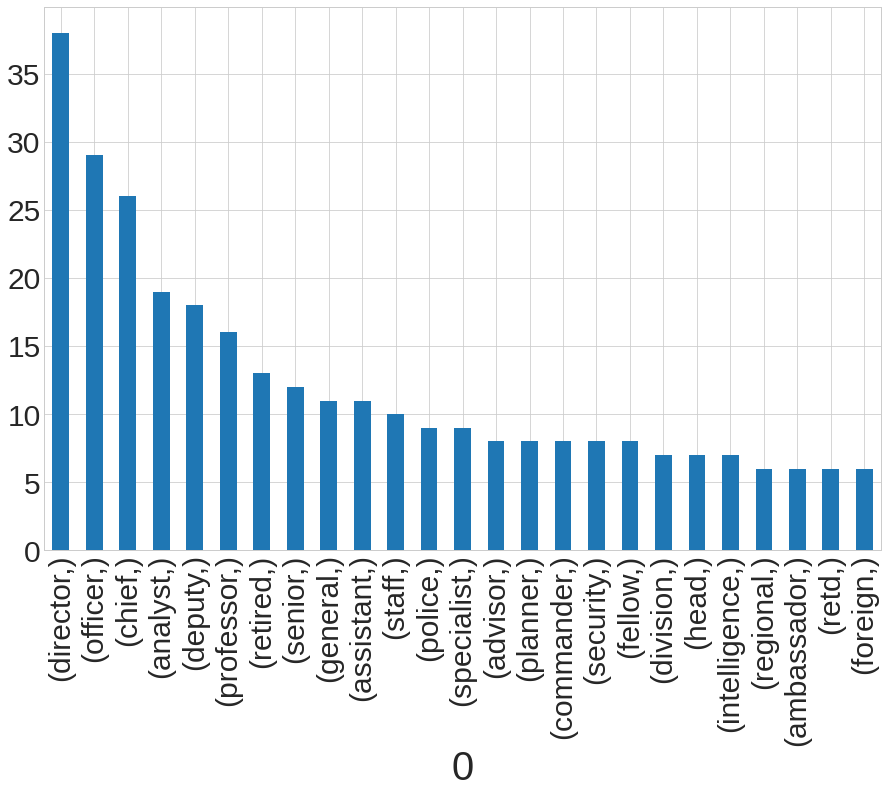

In [35]:
#table showing most common words in subject
i = []
for row in df['JobTitle']:
  for x in row:
    i.append(x)
j = pd.DataFrame(i)
j.value_counts()[:25].plot(kind='bar')

from collections import Counter
Counter = Counter(i)
most_occur = Counter.most_common(50)  #350 is max unique words
most = pd.DataFrame(most_occur).T
most

Rejoin the job titles

In [36]:
#Create new "joined" column - needed for Count Vectorization in next problem
# - Count Vectorization gets triped up over a list of strings, needs solid list
#  This hits "undo" on Tokenization

df['Joined'] = df.JobTitle.apply(' '.join)

for loop in range(1,5):
  print(df['Joined'][loop])


senior advisor
south east asia branch chief cg lno
professor
masters marine affairs candidate


Vectorize

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

features_to_extract = 10

vectorizer = CountVectorizer(max_features = features_to_extract) 

X = vectorizer.fit_transform(df.Joined).toarray()  # new variable - input to the model

# Printing the identified Unique words along with their indices
print("Vocabulary: ", vectorizer.vocabulary_)

most_occur = Counter.most_common(features_to_extract)
most = pd.DataFrame(most_occur)
most



Vocabulary:  {'senior': 9, 'chief': 2, 'professor': 7, 'director': 4, 'analyst': 0, 'retired': 8, 'assistant': 1, 'officer': 6, 'deputy': 3, 'general': 5}


,0,1
0,director,38
1,officer,29
2,chief,26
3,analyst,19
4,deputy,18
5,professor,16
6,retired,13
7,senior,12
8,assistant,11
9,general,11


Vectorize applied to data

In [38]:
for loop in range(1,10):
  print(df['Joined'][loop])

print(" ")
print("------")
print(" ")

print(X[1:10])

# 'air': 1   2nd column is if the text contains "air"
# 'coordination': 2    3rd column is if the text contains "coordination"

#  The X that results can be used in any modeling method!

# Vocabulary: 1st column =Analyst, 2nd = chief, 3rd = deputy, 4th = director, 5th = officer

senior advisor
south east asia branch chief cg lno
professor
masters marine affairs candidate
intel specialist
soj7 director
fellow
supervisory special agent
exercise scenario developer
 
------
 
[[0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


#Classical Modeling

Create a model using the most common 20 words

------
Accuracy = 0.8493150684931506
Balanced Accuracy = 0.7275828460038987
------
              precision    recall  f1-score   support

Likes Lattes       0.84      0.98      0.91        54
        Nope       0.90      0.47      0.62        19

    accuracy                           0.85        73
   macro avg       0.87      0.73      0.76        73
weighted avg       0.86      0.85      0.83        73



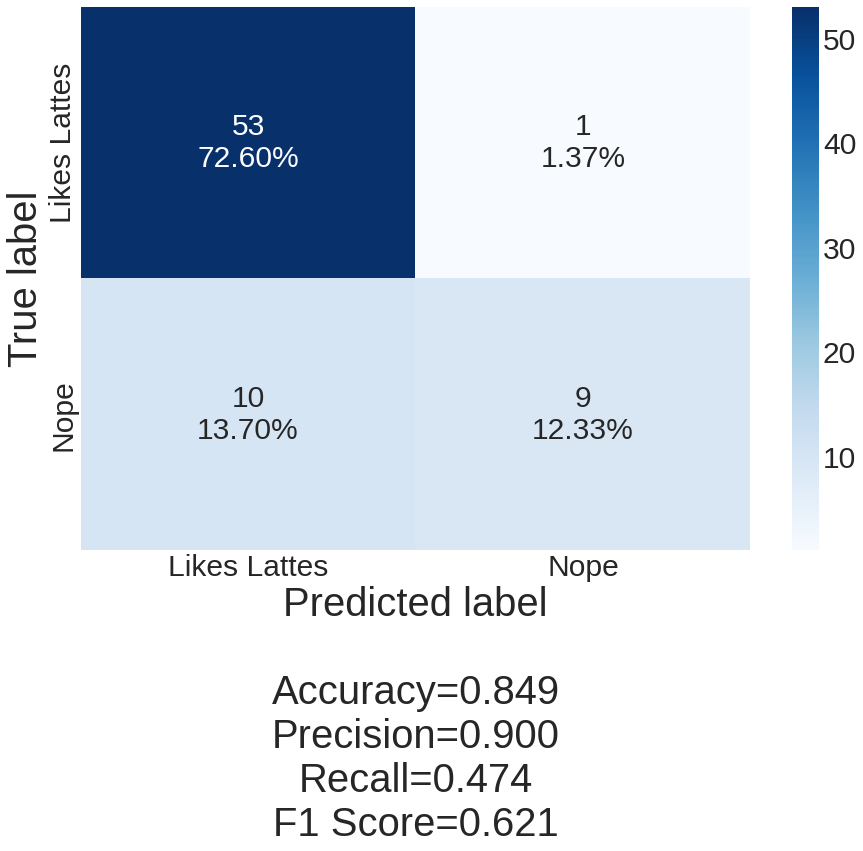

In [39]:
#Feature Matrix Creation
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 2)   # 20 words
X = vectorizer.fit_transform(df.Joined).toarray()

# print(X)
print("------")

# Split out y variable, make it boolean
y = df.iloc[:, 6]
y.astype(bool)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Naive Bayes
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

#Predict
y_pred = classifier.predict(X_test)

# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score (y_test, y_pred)
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy = balanced_accuracy_score (y_test, y_pred)
print(f"Accuracy = {accuracy}")
print(f"Balanced Accuracy = {balanced_accuracy}")

# The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. 
# It is defined as the average of recall obtained on each class.

print("------")

############# Classification report
from sklearn.metrics import classification_report

target_names = ['Likes Lattes', 'Nope']
print(classification_report(y_test, y_pred, target_names=target_names))


############## Confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)

make_confusion_matrix(cf_matrix, 
                      categories=target_names)

Model sweep over number of most-common input words

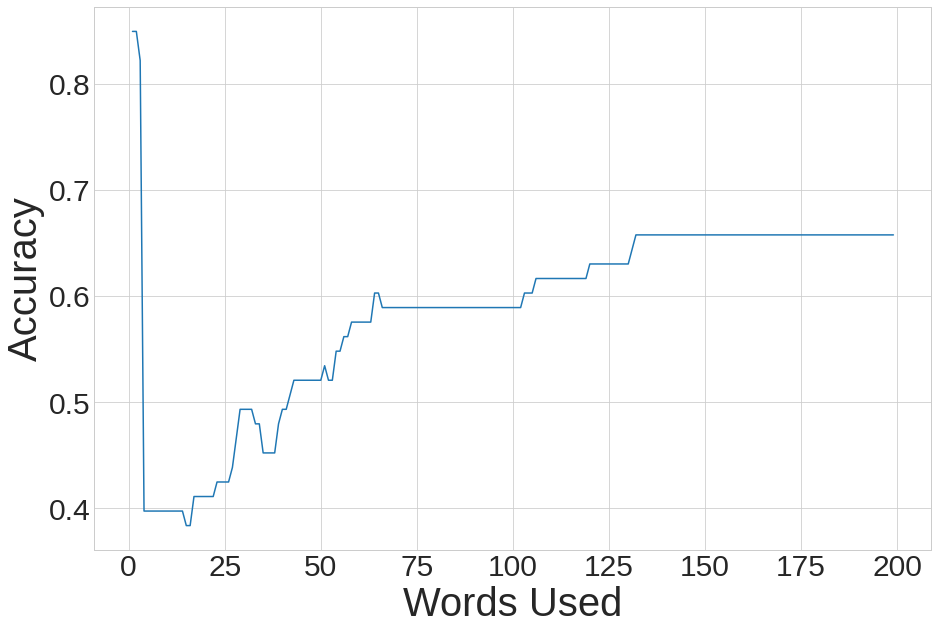

In [40]:
#This code section performs a sweep and plots out final accuracy based on used words
#Code uses a Naive Bayes classification prediction algorithm from sklearn
import matplotlib.pyplot as plt
max_words = 200

accuracy_to_save = []
balanced_accuracy_to_save = []

for max_f in range(1,max_words):

  #Feature Matrix Creation
  from sklearn.feature_extraction.text import CountVectorizer
  vectorizer = CountVectorizer(max_features = max_f)  
  X = vectorizer.fit_transform(df.Joined).toarray()

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


  #Naive Bayes
  from sklearn.naive_bayes import GaussianNB
  classifier = GaussianNB()
  classifier.fit(X_train, y_train)

  #Predict
  y_pred = classifier.predict(X_test)

  # Accuracy
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score (y_test, y_pred)
  from sklearn.metrics import balanced_accuracy_score
  balanced_accuracy = balanced_accuracy_score (y_test, y_pred)
#  print(accuracy)
#  print(balanced_accuracy)

  balanced_accuracy_to_save.append(balanced_accuracy)
  accuracy_to_save.append(accuracy)

#plt.plot(range(1,max_words), balanced_accuracy_to_save, label="balanced_accuracy")

plotting=1
if plotting:
  fig = plt.plot(range(1,max_words), accuracy_to_save, label="accuracy")
  plt.xlabel('Words Used')
  plt.ylabel('Accuracy')
  fig


In [41]:
for loop in range(1,150):
  print(f"words={loop} accuracy={accuracy_to_save[loop-1]} ")



words=1 accuracy=0.8493150684931506 
words=2 accuracy=0.8493150684931506 
words=3 accuracy=0.821917808219178 
words=4 accuracy=0.3972602739726027 
words=5 accuracy=0.3972602739726027 
words=6 accuracy=0.3972602739726027 
words=7 accuracy=0.3972602739726027 
words=8 accuracy=0.3972602739726027 
words=9 accuracy=0.3972602739726027 
words=10 accuracy=0.3972602739726027 
words=11 accuracy=0.3972602739726027 
words=12 accuracy=0.3972602739726027 
words=13 accuracy=0.3972602739726027 
words=14 accuracy=0.3972602739726027 
words=15 accuracy=0.3835616438356164 
words=16 accuracy=0.3835616438356164 
words=17 accuracy=0.410958904109589 
words=18 accuracy=0.410958904109589 
words=19 accuracy=0.410958904109589 
words=20 accuracy=0.410958904109589 
words=21 accuracy=0.410958904109589 
words=22 accuracy=0.410958904109589 
words=23 accuracy=0.4246575342465753 
words=24 accuracy=0.4246575342465753 
words=25 accuracy=0.4246575342465753 
words=26 accuracy=0.4246575342465753 
words=27 accuracy=0.43835616

#Neural network
single vocabulary 

Epoch 1/40
8/8 [==============================] - 1s 21ms/step - loss: 0.7005 - accuracy: 0.5605 - val_loss: 0.6892 - val_accuracy: 0.6591
Epoch 2/40
8/8 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 0.6371 - val_loss: 0.6823 - val_accuracy: 0.6818
Epoch 3/40
8/8 [==============================] - 0s 7ms/step - loss: 0.6879 - accuracy: 0.6532 - val_loss: 0.6758 - val_accuracy: 0.7045
Epoch 4/40
8/8 [==============================] - 0s 5ms/step - loss: 0.6818 - accuracy: 0.6815 - val_loss: 0.6693 - val_accuracy: 0.7500
Epoch 5/40
8/8 [==============================] - 0s 5ms/step - loss: 0.6759 - accuracy: 0.6815 - val_loss: 0.6631 - val_accuracy: 0.7727
Epoch 6/40
8/8 [==============================] - 0s 7ms/step - loss: 0.6704 - accuracy: 0.7097 - val_loss: 0.6568 - val_accuracy: 0.7955
Epoch 7/40
8/8 [==============================] - 0s 6ms/step - loss: 0.6643 - accuracy: 0.7097 - val_loss: 0.6514 - val_accuracy: 0.8182
Epoch 8/40
8/8 [=================

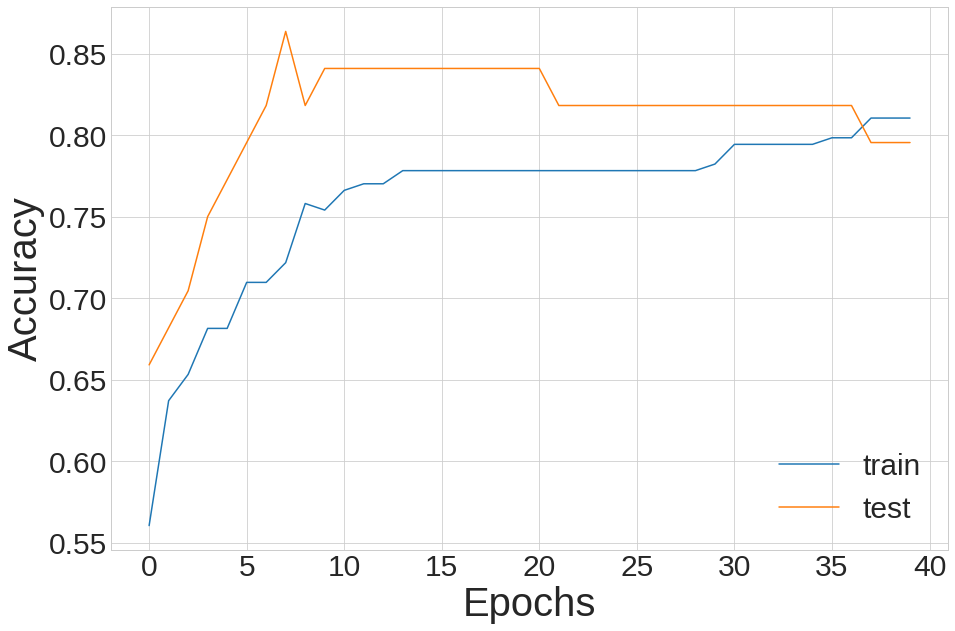

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
import tensorflow
from keras.layers import Flatten

MAX_NB_WORDS = 50  # The maximum number of words to be used (most frequent) aka vocabulary size

# error prevention
from keras import backend as K 
K.clear_session()

# create vocab from max words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = MAX_NB_WORDS)  
X = vectorizer.fit_transform(df.Joined).toarray()

# Split out y variable, make it 0 and 1
y = df.iloc[:, 6]
y = (y=='YES')*1

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = Sequential()

model.add(Dense(5, input_dim=MAX_NB_WORDS, activation='relu'))

#model.add(Dense(50, activation='relu'))
#model.add(Dense(40, activation='relu'))
#model.add(Dense(20, activation='relu'))
#model.add(Dense(10, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

epochs = 40
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.15)



# evaluate the keras model on test set
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))



plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();


Sweep of vocabulary

3/3 [==============================] - 0s 4ms/step - loss: 0.6229 - accuracy: 0.7397
1 words: Train/Test set Accuracy: 0.767123281955719/0.7397260069847107
3/3 [==============================] - 0s 4ms/step - loss: 0.5925 - accuracy: 0.8493
2 words: Train/Test set Accuracy: 0.8219178318977356/0.8493150472640991
3/3 [==============================] - 0s 4ms/step - loss: 0.5907 - accuracy: 0.7397
3 words: Train/Test set Accuracy: 0.767123281955719/0.7397260069847107
3/3 [==============================] - 0s 3ms/step - loss: 0.6040 - accuracy: 0.7397
4 words: Train/Test set Accuracy: 0.767123281955719/0.7397260069847107
3/3 [==============================] - 0s 4ms/step - loss: 0.5025 - accuracy: 0.7808
5 words: Train/Test set Accuracy: 0.7808219194412231/0.7808219194412231
3/3 [==============================] - 0s 4ms/step - loss: 0.5142 - accuracy: 0.8630
6 words: Train/Test set Accuracy: 0.835616409778595/0.8630136847496033
3/3 [==============================] - 0s 4ms/step - loss: 0.4

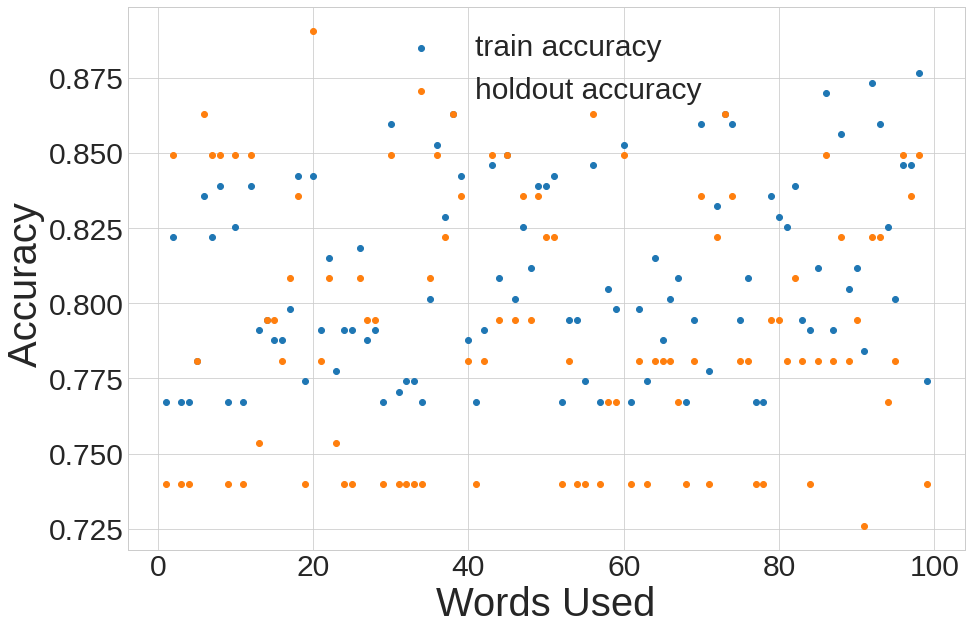

In [45]:
max_words = 100 # 350 is maximum unique words in this dataset's vocab

accuracy_test_to_save = []
accuracy_train_to_save = []

for max_f in range(1,max_words):  

  # error prevention
  from keras import backend as K 
  K.clear_session()

  # create vocab from max words
  from sklearn.feature_extraction.text import CountVectorizer
  vectorizer = CountVectorizer(max_features = max_f)  
  X = vectorizer.fit_transform(df.Joined).toarray()

  # Split out y variable, make it 0 and 1
  y = df.iloc[:, 6]
  y = (y=='YES')*1

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

  model = Sequential()

  model.add(Dense(5, input_dim=max_f, activation='relu'))

  #model.add(Dense(50, activation='relu'))
  #model.add(Dense(40, activation='relu'))
  #model.add(Dense(20, activation='relu'))
  #model.add(Dense(10, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

  epochs = 40
  batch_size = 32

  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.15, verbose=0)



  # evaluate the keras model on test set
  acc_train = model.evaluate(X_train,y_train)
  acc_test = model.evaluate(X_test,y_test)
  print(f'{max_f} words: Train/Test set Accuracy: {acc_train[1]}/{acc_test[1]}')

  accuracy_train_to_save.append(acc_train[1])
  accuracy_test_to_save.append(acc_test[1])


fig = plt.scatter(range(1,max_words), accuracy_train_to_save, label="train accuracy")
fig = plt.scatter(range(1,max_words), accuracy_test_to_save, label="holdout accuracy")

plt.xlabel('Words Used')
plt.ylabel('Accuracy ')
# plt.ylim(0.3, 0.75)
plt.legend()

38 words seems best, evaluate metrics more thoroughly

Epoch 1/40
8/8 [==============================] - 1s 26ms/step - loss: 0.6793 - accuracy: 0.7298 - val_loss: 0.6708 - val_accuracy: 0.6818
Epoch 2/40
8/8 [==============================] - 0s 6ms/step - loss: 0.6720 - accuracy: 0.7702 - val_loss: 0.6631 - val_accuracy: 0.7273
Epoch 3/40
8/8 [==============================] - 0s 6ms/step - loss: 0.6648 - accuracy: 0.7782 - val_loss: 0.6549 - val_accuracy: 0.7955
Epoch 4/40
8/8 [==============================] - 0s 6ms/step - loss: 0.6563 - accuracy: 0.7742 - val_loss: 0.6471 - val_accuracy: 0.7955
Epoch 5/40
8/8 [==============================] - 0s 6ms/step - loss: 0.6488 - accuracy: 0.7661 - val_loss: 0.6388 - val_accuracy: 0.8182
Epoch 6/40
8/8 [==============================] - 0s 6ms/step - loss: 0.6406 - accuracy: 0.7702 - val_loss: 0.6301 - val_accuracy: 0.8182
Epoch 7/40
8/8 [==============================] - 0s 6ms/step - loss: 0.6325 - accuracy: 0.7661 - val_loss: 0.6209 - val_accuracy: 0.8182
Epoch 8/40
8/8 [=================

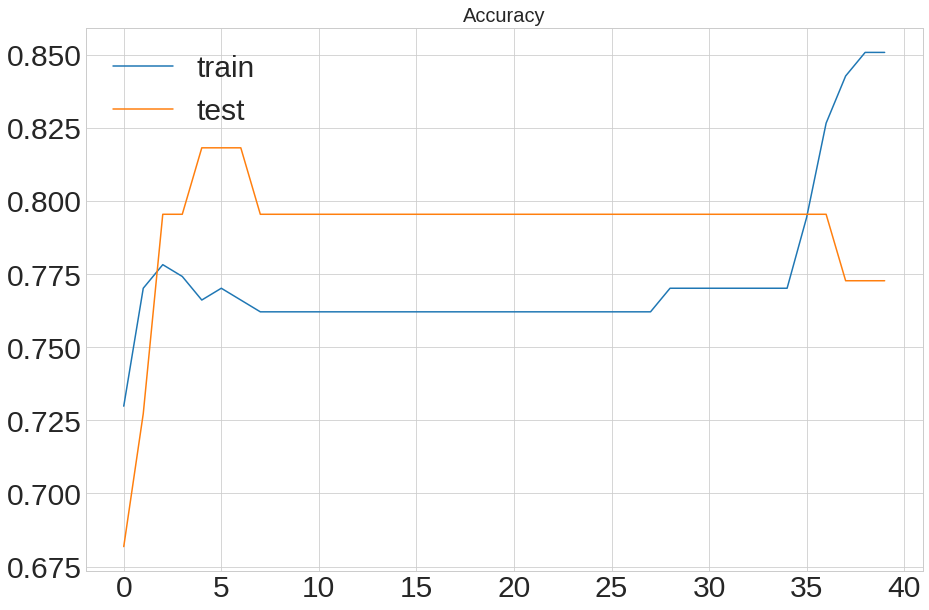

3/3 [==============================] - 0s 4ms/step - loss: 0.4189 - accuracy: 0.8356
38 words: Train/holdout set Accuracy: 0.8424657583236694/0.835616409778595
---------- Metrics for test dataset -------
Accuracy test =   0.8356164383561644
              precision    recall  f1-score   support

           0       0.83      0.98      0.90        54
           1       0.89      0.42      0.57        19

    accuracy                           0.84        73
   macro avg       0.86      0.70      0.73        73
weighted avg       0.84      0.84      0.81        73

---------- Metrics for train dataset -------
Accuracy train = 0.8424657534246576
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       224
           1       0.87      0.38      0.53        68

    accuracy                           0.84       292
   macro avg       0.85      0.68      0.72       292
weighted avg       0.85      0.84      0.82       292

---------- Metrics for a

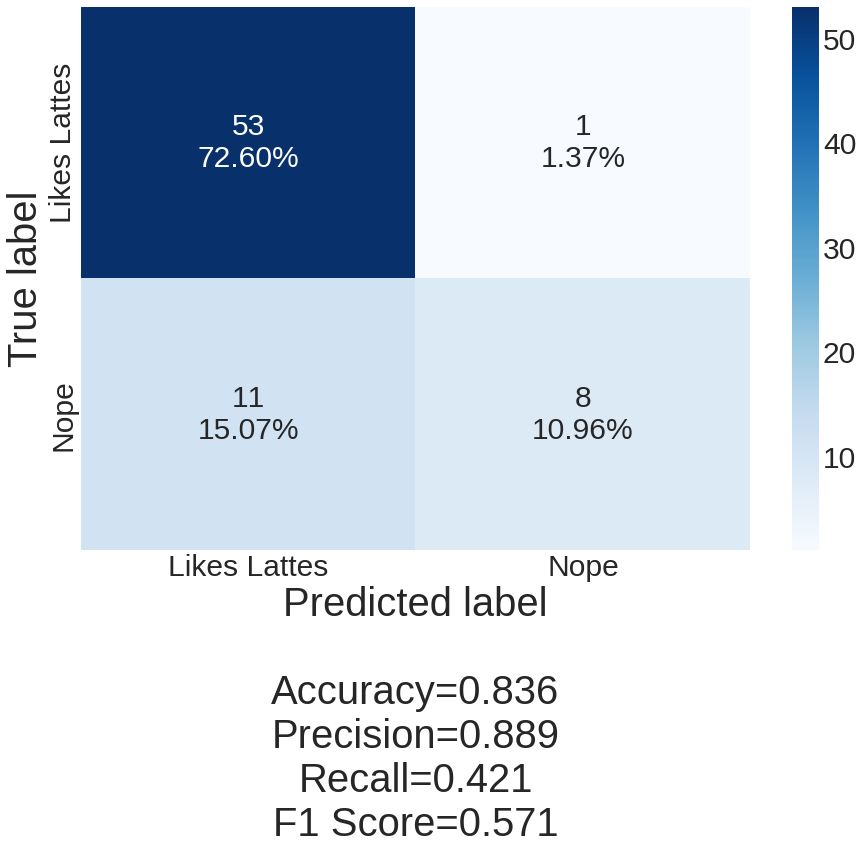

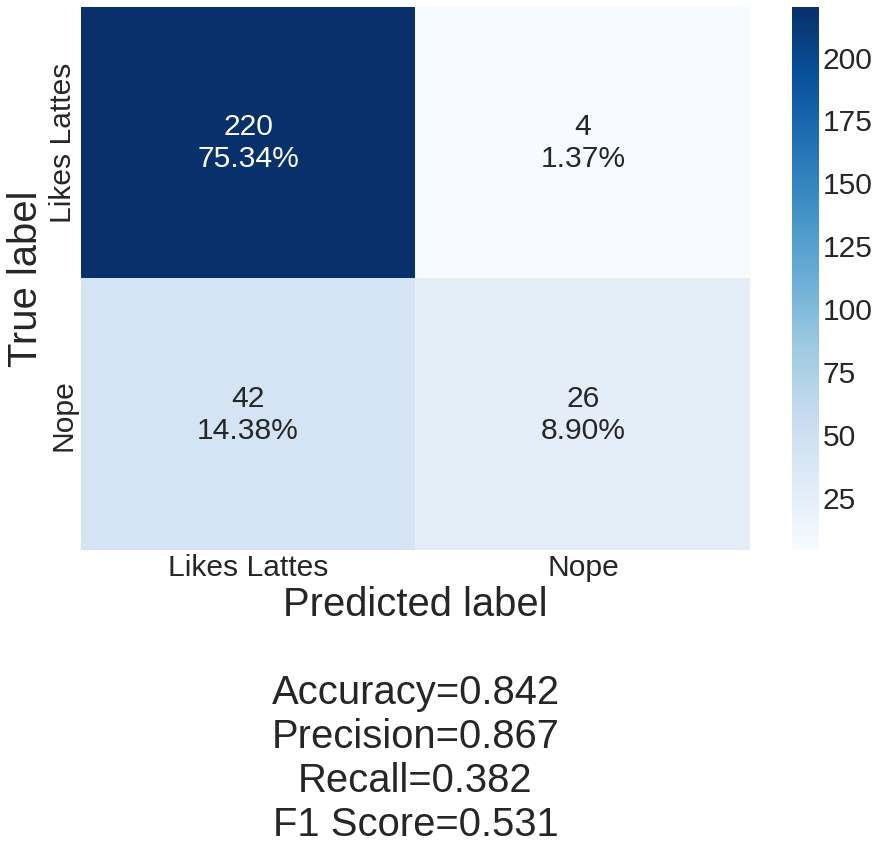

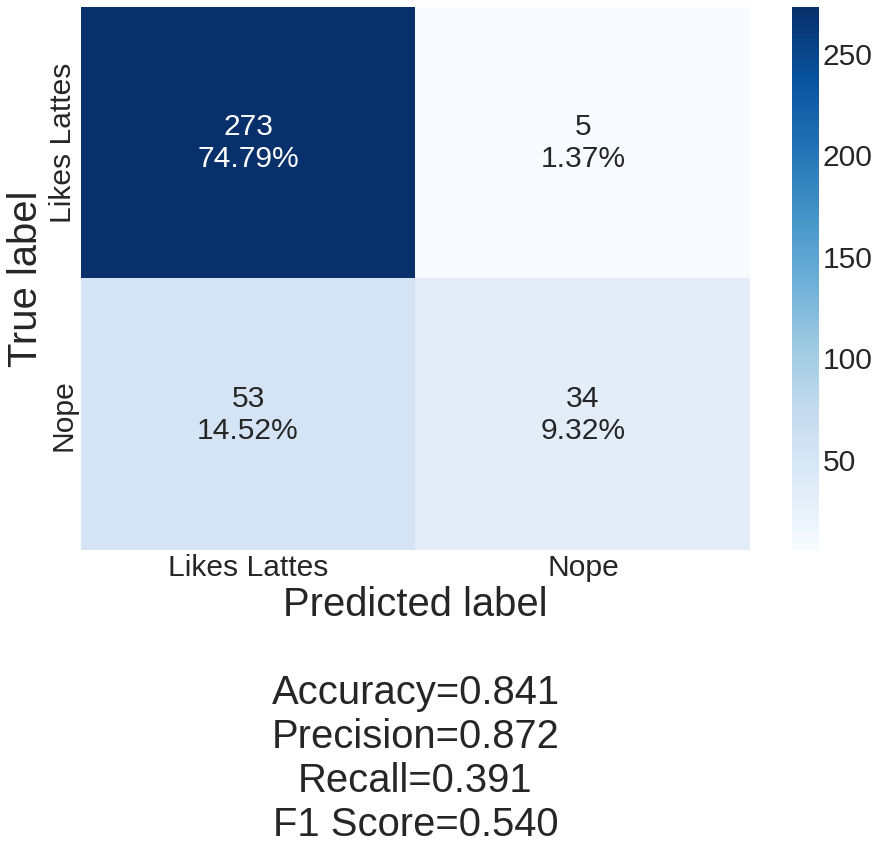

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
import tensorflow
from keras.layers import Flatten

max_f = 38  # The maximum number of words to be used (most frequent) aka vocabulary size

# error prevention
from keras import backend as K 
K.clear_session()

# create vocab from max words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = max_f)  
X = vectorizer.fit_transform(df.Joined).toarray()

# Split out y variable, make it 0 and 1
y = df.iloc[:, 6]
y = (y=='YES')*1

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = Sequential()

model.add(Dense(5, input_dim=max_f, activation='relu'))

model.add(Dense(5, activation='relu'))
# model.add(Dense(40, activation='relu'))
# model.add(Dense(20, activation='relu'))
# model.add(Dense(10, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

epochs = 40
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.15)



# evaluate the keras model on test set
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# evaluate the keras model on test set
acc_train = model.evaluate(X_train,y_train)
acc_test = model.evaluate(X_test,y_test)
print(f'{max_f} words: Train/holdout set Accuracy: {acc_train[1]}/{acc_test[1]}')



# ---------- Thorough metric evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#Predict
y_pred_test = np.round(model.predict(X_test))
y_pred_train = np.round(model.predict(X_train))
y_pred_all = np.round(model.predict(X))

# Metrics for Test
print("---------- Metrics for test dataset -------")

print(f"Accuracy test =   { accuracy_score (y_test, y_pred_test) }")

cf_matrix = confusion_matrix(y_test, y_pred_test)
make_confusion_matrix(cf_matrix, 
                      categories=target_names)


print(classification_report(y_test, y_pred_test))



print("---------- Metrics for train dataset -------")

print(f"Accuracy train = { accuracy_score (y_train, y_pred_train) }")

cf_matrix = confusion_matrix(y_train, y_pred_train)
make_confusion_matrix(cf_matrix, 
                      categories=target_names)



print(classification_report(y_train, y_pred_train))


print("---------- Metrics for all -------")

print(f"Accuracy train = { accuracy_score (y, y_pred_all) }")

cf_matrix = confusion_matrix(y, y_pred_all)
make_confusion_matrix(cf_matrix, 
                      categories=target_names)



print(classification_report(y, y_pred_all))
